# Finding Causality in Big Data: An Introduction


### Shirin Mojarad, Ph.D.
### Data Scientist, McGraw-Hill Education

@shirinmojarad

Shirin.mojarad@gmail.com

https://github.com/Shirinn/BostonDataFest2016

# Agenda 

* Introduction to causality
* How to establish causality
* Randomized controlled trials
* Causal inference
* Your Toolkit For Finding Causality

# Your Toolkit For Finding Causality

# Why finding causality?

### It’s all about relationships

### Who's fault is it?


* Does getting heath insurance make you healthier?
* Does the new curriculum going to help students learn better?
* Does the new marketing campaign attract more sales?
* Does the new diet help you lose weight?


# Why not correlation

* Basis of many scientific hypothesis
* Causation imply correlation
* Complex correlational designs allow for some limited causal inference


# Correlation Or Causation?

* Directionality problem

* Third-variable problem


<img src='Images/correlation_problems.jpeg' width=400>


# Assumptions in Causality 

* An effect could have multiple causes
* Each cause might have different weights
* There might be hidden or unknown causes


# How to establish causality?

## Randomized controlled trials (RCT)



<img src="Images/RCT.jpg" width=900>


## Hidden elements

* Covariate: any causes, besides treatment, that can affect outcome
* Covariate balance: treated and control groups with similar covariate distributions


## Why Randomization?

* Randomization balances out all other causes (covariates), besides treatment, between treatment and control groups.

<img src='Images/covbal.png' width=300>

# Problems with RCT

* Expensive
* Bias
* Covariate balance
* Ethics


# Causal Inference

<img src='Images/1.png' width=500>

<img src='Images/2.png' width=500>

<img src='Images/3.png' width=500>

<img src='Images/4.png' width=200>

# Causal Inference

<img src='Images/PSM.jpg' width=500>

# Causal Inference in 5 Steps

<ol type="1">
<li>Identify covariates from observational data</li>
<li>Choose a matching metric </li>
<li>Execute a matching algorithm</li>
<li>Examine covariate balance</li>
<li>Estimate treatment effects </li>
</ol>

# Data

We want to study the effect of a training program on individuals’ earnings.

* Data are from the National Supported Work project and Dehejia and Wahba (1999)
* Treatment is if a person received training (treatment)
* Independent variables are age, education, and married
* Outcome is real earnings (RE78)
* We need to find matches for the 185 treated observations and then compare outcomes

## Import required libraries and data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import binom, hypergeom, gaussian_kde
from scipy.stats import ttest_ind
import math

In [2]:
df = pd.read_csv('matching_earnings.csv')
print(df.shape)
df.head()

(2675, 5)


,TREAT,AGE,EDUC,MARR,EARNINGS
0,0,40,8,1,53198.2
1,0,54,0,1,20540.4
2,0,47,10,1,55710.3
3,0,32,8,1,59109.1
4,0,47,8,1,38568.7


In [3]:
df.groupby('TREAT').size()

TREAT
0        2490
1         185
dtype: int64

Note from the output that not all of the control observations might be used as matches for the 185 treated observations.

## Define treatment, outcome and covariates

In [4]:
# treatment
Tr = df.TREAT

# outcome
Y = df.EARNINGS
Y0 = df.EARNINGS[df.TREAT==0]
Y1 = df.EARNINGS[df.TREAT==1]

# covariates
X = df[['AGE', 'EDUC', 'MARR']]

# 1 Identify covariates from observational data
## 1.1 Difference-in-means: outcome variable

* Effectiveness of treatment (effect on RE78 expression)
* Question: does treatment affect RE78 expression (outcome)?


In [5]:
df.groupby('TREAT')['EARNINGS'].mean().reset_index()

,TREAT,EARNINGS
0,0,21553.921332
1,1,6349.145368


In [6]:
# Mean difference 
Y1.mean() - Y0.mean()

-15204.775964721586

It seems that individuals who did not receive training earn $15k on average more than those who received the training.

## 1.2 T-test, significance and effect size

###T-test (t)
A form of hypothesis testing, testing the difference between two populations averages. The t-value measures the size of the difference relative to the variation in your sample data. 


### Statistical Significance (p-value)
A t-test’s statistical significance indicates whether or not the difference between two groups’ averages most likely reflects a “real” difference in the population from which the groups were sampled.

### Effect size (d)

Effect size is a quantitative measure of the strength of a relationship. Effect size or Cohen's d is the difference in the two groups' means divided by the average of their standard deviations. 


<img src="Images/d.png" width=300>

where pooled standard deviation is: 

<img src="Images/spooled.png" width=400>

* 0.2 be considered a 'small' effect size
* 0.5 represents a 'medium' effect size 
* 0.8 a 'large' effect size

In [7]:
# t-statistic & p-value for difference in outcome of two groups
def hypothesisTest(data, attribute, group):
    x = data[attribute][df[group]==1]
    y = data[attribute][df[group]==0]
    # t-statistic & p-value for difference in outcome of two groups
    t = ttest_ind(x, y)[0]
    p = ttest_ind(x, y)[1]
    # Confidence intervals
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    CI = str(round(cm.tconfint_diff(usevar='unequal')[0]))+' - '+str(round(cm.tconfint_diff(usevar='unequal')[1]))
    # Cohen's d
    pooledvar = math.sqrt((pow(x.std(),2) + (pow(y.std(),2)))/2)
    d = (x.mean()-y.mean()) / pooledvar
    # create dataframe
    tablelist = []
    tablerow = [attribute,x.mean()-y.mean(),t,p,CI,d]
    tablelist.append(tablerow)
    out = pd.DataFrame(tablelist)
    out.columns = ['Attribute','Mean Difference','t-value','p-value','95% Confidence Intervals',"Cohen's d"]

    return out

In [8]:
hypothesisTest(df, 'EARNINGS', 'TREAT')

,Attribute,Mean Difference,t-value,p-value,95% Confidence Intervals,Cohen's d
0,EARNINGS,-15204.775965,-13.168705,2.032910e-38,-16498.0 - -13912.0,-1.233544


The difference-in-means is significant and the effect size is large.

# 1.3 Difference-in-means: pre-treatment covariates
### We’ll work with the following covariates:

* Age
* Education
* Marriage

Let’s get the difference-in-means for each of these covariates, by the treatment status:

EARNINGS


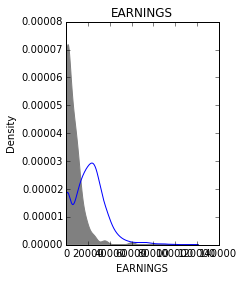

AGE


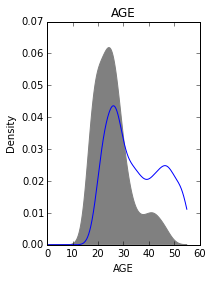

EDUC


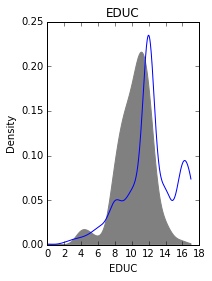

MARR


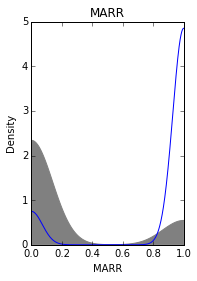

In [9]:
for att in ['EARNINGS' ,'AGE' , 'EDUC', 'MARR']:
    print att
    pre = pd.DataFrame({'groups':Tr, 'attribute':df[att]})    

    plt.figure(1)
    plt.subplot(121)
    density0 = gaussian_kde(pre.attribute[pre.groups==0])
    density1 = gaussian_kde(pre.attribute[pre.groups==1])
    xs = np.linspace(0,df[att].max(),1000)
    plt.plot(xs,density0(xs),color='blue')
    plt.fill_between(xs,density1(xs),color='gray')
    plt.title(att)
    plt.xlabel(att)
    plt.ylabel('Density')
    plt.show()

In [10]:
df.groupby('TREAT')['EARNINGS','AGE', 'EDUC', 'MARR'].mean().reset_index()

,TREAT,EARNINGS,AGE,EDUC,MARR
0,0,21553.921332,34.850602,12.116867,0.866265
1,1,6349.145368,25.816216,10.345946,0.189189


* What do you see? Take a moment to reflect on what these differences suggest for the relationship of interest (that between treated and not treated).

We can carry out t-tests to evaluate whether these means are statistically distinguishable:

In [11]:
b = pd.DataFrame()
for att in ['EARNINGS','AGE', 'EDUC', 'MARR']:
    a = []
    a = hypothesisTest(df, att, 'TREAT')
    b = pd.concat([b,a],0)
b

,Attribute,Mean Difference,t-value,p-value,95% Confidence Intervals,Cohen's d
0,EARNINGS,-15204.775965,-13.168705,2.032910e-38,-16498.0 - -13912.0,-1.233544
0,AGE,-9.034386,-11.568216,3.094941e-30,-10.0 - -8.0,-1.009433
0,EDUC,-1.770922,-7.692919,2.007808e-14,-2.0 - -1.0,-0.680517
0,MARR,-0.677076,-25.806985,2.561532e-131,-1.0 - -1.0,-1.842335


## 2 Choose a matching metric

Matching methods examine how to best choose treated and control subjects for comparison. 

#### Propensity score matching

Matching treated and control subjects using propensity score:

                                    P(X) = Pr (Tr=1|X)

#### Mahalanobis distance matching

Matching treated and control subjects using Mahalanobis distance. Mahalanobis distance between two vectors, x and y, where S is the covariance matrix is:

<img src='Images/MD.png' width=200> 





## 2.1 Propensity score matching

Match treated and untreated observations on the estimated probability of being treated (propensity score)

P(X) = Pr (Tr=1|X)

We can estimate the propensity scores using logistic regression.

In [12]:
####### Using LogisticRegression from sklearn.linear_model    
propensity = LogisticRegression()
propensity.fit(X, Tr)
propensityScoreLR = propensity.predict_proba(X)[:,1]
propensityScoreLR

array([ 0.02326526,  0.05967483,  0.00852138, ...,  0.31592987,
        0.22350654,  0.01377988])

In [13]:
df = pd.read_csv('matching_earnings.csv')
print df.columns
print df.shape

Index([u'TREAT', u'AGE', u'EDUC', u'MARR', u'EARNINGS'], dtype='object')
(2675, 5)


In [14]:
####### Using GLM
import statsmodels.genmod.generalized_linear_model as sm
glm_binom = sm.GLM(Tr, X, family=sm.families.Binomial())
res = glm_binom.fit()
# print res.summary()
propensityScoreGLM = res.fittedvalues
df = pd.concat([df,propensityScoreGLM],1)
df.columns = ['TREAT','AGE','EDUCATION','MARRIAGE','EARNINGS' , 'Propensity Score']
print '\n'+ 'Propensity Scores added: '
df.head()


Propensity Scores added: 


,TREAT,AGE,EDUCATION,MARRIAGE,EARNINGS,Propensity Score
0,0,40,8,1,53198.2,0.017519
1,0,54,0,1,20540.4,0.019986
2,0,47,10,1,55710.3,0.014304
3,0,32,8,1,59109.1,0.019931
4,0,47,8,1,38568.7,0.015646


## 3 Execute a matching algorithm

There are several variants of matching: 
* one-to-one matching
* one-to-many matching 
* with or without a caliper, and with or without replacement

Variants of the methods are examined in the following paper:

</br> Austin, P. C. (2014), A comparison of 12 algorithms for matching on the propensity score. Statist. Med., 33: 1057–1069. doi: 10.1002/sim.6004

In [16]:
# one-to-one matching
N = len(Tr)
N1 = Tr[Tr == 1].index; N2 = Tr[Tr == 0].index
g1, g2 = propensityScoreGLM[Tr == 1], propensityScoreGLM[Tr == 0]

## Check if treatment groups got flipped - the smaller should correspond to N1/g1
if len(N1) > len(N2):
   N1, N2, g1, g2 = N2, N1, g2, g1

## match treatment and control group
matches = {}
caliper = 0.05
replace = False

for m in N1:
    dist = abs(g1[m] - g2)
    if (dist.min() <= caliper) or not caliper:
            matches[m] = dist.argmin()  
            if not replace:
                g2 = g2.drop(matches[m])

print 'Sample matches: '
{k: matches[k] for k in matches.keys()[:5]}

Sample matches: 


{2560: 241, 2561: 264, 2562: 323, 2563: 2343, 2564: 2107}

In [17]:
# Matched data:
tr = matches.keys()
ctrl = matches.values()
temp = pd.concat([df.ix[tr],df.ix[ctrl]])
df_matched = temp.groupby(temp.index).first()
df_matched.groupby('TREAT').size().reset_index()

,TREAT,0
0,0,179
1,1,179


## 4 Examine covariate balance
### 4.1 Visual inspection

Plot density of propensity scores and covariates for each group before and after matching

In [18]:
def plotMatching(data, attribute, groups, matches):
    pre = pd.DataFrame({'groups':data[groups], 'propensity':data[attribute]})    

    tr = matches.keys()
    ctrl = matches.values()
    temp = pd.concat([pre.ix[tr], pre.ix[ctrl]])
    post = temp.groupby(temp.index).first()


    plt.figure(1)
    plt.subplot(121)
    density0 = gaussian_kde(pre.propensity[pre.groups==0])
    density1 = gaussian_kde(pre.propensity[pre.groups==1])
    xs = np.linspace(0,data[attribute].max(),1000)
    plt.plot(xs,density0(xs),color='blue')
    plt.fill_between(xs,density1(xs),color='gray')
    plt.title('Before Matching')
    plt.xlabel(att)
    plt.ylabel('Density')

    plt.subplot(122)
    density0_post = gaussian_kde(post.propensity[post.groups==0])
    density1_post = gaussian_kde(post.propensity[post.groups==1])
    xs = np.linspace(0,data[attribute].max(),1000)
    plt.plot(xs,density0_post(xs),color='blue')
    plt.fill_between(xs,density1_post(xs),color='gray')
    plt.title('After Matching')
    plt.xlabel(att)
    plt.ylabel('Density')
    plt.show()

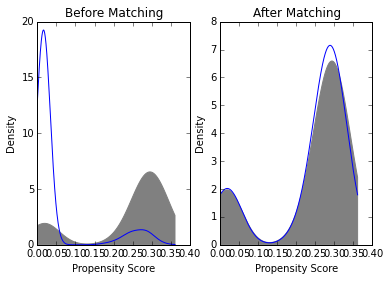

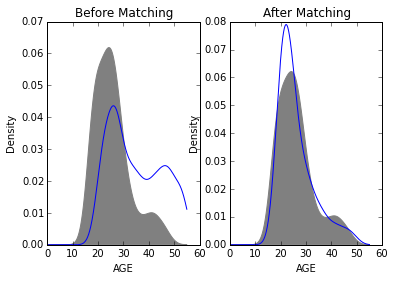

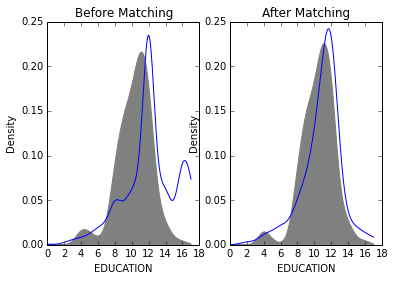

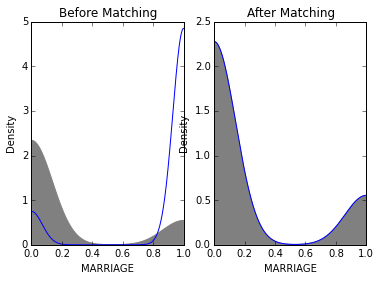

In [19]:
for att in ['Propensity Score','AGE', 'EDUCATION', 'MARRIAGE']:
    plotMatching(df, att, 'TREAT', matches)
from IPython.display import HTML
HTML("<font color='#666666'>Gray = Treatment Group</font><br>"
     "<font color='6666ff'>Blue = Control Group </font>")

### 4.2 Difference-in-means

In [20]:
def balanceCheck(data, attribute, group):
    means = data[[group, attribute]].groupby(group).mean().reset_index()
    dist = abs(means.diff()).ix[1]
    std = data[[group, attribute]].groupby(group).std().reset_index()
    n = data[group].value_counts()
    se = std.apply(lambda(s): np.sqrt(s[0]**2/n[0] + s[1]**2/n[1]))
    tablelist = []
    tablerow = [attribute,dist[1],se[1]]
    tablelist.append(tablerow)
    out = pd.DataFrame(tablelist)
    out.columns = ['Attribute','difference of means by group','Standard error for covariates by group']
    return out

In [21]:
b = pd.DataFrame()
for att in ['EARNINGS','AGE', 'EDUCATION', 'MARRIAGE']:
    a = []
    a = balanceCheck(df, att, 'TREAT')
    b = pd.concat([b,a],0)
b

,Attribute,difference of means by group,Standard error for covariates by group
0,EARNINGS,15204.775965,657.076476
0,AGE,9.034386,0.566131
0,EDUCATION,1.770922,0.160213
0,MARRIAGE,0.677076,0.029669


In [22]:
b = pd.DataFrame()
for att in ['EARNINGS','AGE', 'EDUCATION', 'MARRIAGE']:
    a = []
    a = hypothesisTest(df_matched, att, 'TREAT')
    b = pd.concat([b,a],0)
b

,Attribute,Mean Difference,t-value,p-value,95% Confidence Intervals,Cohen's d
0,EARNINGS,-7931.365609,-7.855315,4.759491e-14,-9918.0 - -5945.0,-0.830333
0,AGE,-0.055866,-0.074906,9.403318e-01,-2.0 - 1.0,-0.007918
0,EDUCATION,-0.391061,-1.745422,8.177423e-02,-1.0 - 0.0,-0.184497
0,MARRIAGE,0.000000,0.000000,1.000000e+00,-0.0 - 0.0,0.000000


Difference in means for covariates is not significant anymore and the effect sizes are negligible.

## 5 Estimate treatment effects

Estimate average treatment effect  on the treated

### 5.1 Computes ATT using difference in means

In [23]:
# Matched outcome
Y0_matched = df_matched.EARNINGS[df.TREAT == 0]
Y1_matched = df_matched.EARNINGS[df.TREAT == 1]

Y1_matched.mean() - Y0_matched.mean()

-7931.3656089385468

@shirinmojarad

Shirin.mojarad@gmail.com

https://github.com/Shirinn/BostonDataFest2016